# Use the 2D-prediction tool to identify inconclusive datasets  


This notebook uses the "LI-Deconstruction" method described in [Wegrzyn et al. 2019](https://dx.doi.org/10.3389/fneur.2019.00655) to determine if a patient's activity map is conclusive enough to be considered useful. The "li" module which we use here is available here: https://github.com/mwegrzyn/laterality-index-deconstruction .

### import modules

In [6]:
import sys
import pickle

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from datetime import datetime
import gc

### load data

In [2]:
data_df = pd.read_csv('../data/interim/csv/info_epi_zscored_zdiff_summarymaps_df.csv',index_col=[0],header=0)

In [ ]:
data_df.tail()

### import our 2D laterality module

In [4]:
sys.path.append('../helper')

In [5]:
import laterality_index_deconstruction as li

### make the predictions

In [ ]:
for p_name in data_df.index:
    print('%s %s'%(p_name,datetime.now()))
    t_im = data_df.loc[p_name,'tMap']
    p_folder = '/'.join(t_im.split('/')[:-1])
    li.make_predict(p_folder,p_name)

### show example predicitons

In [ ]:
p_name

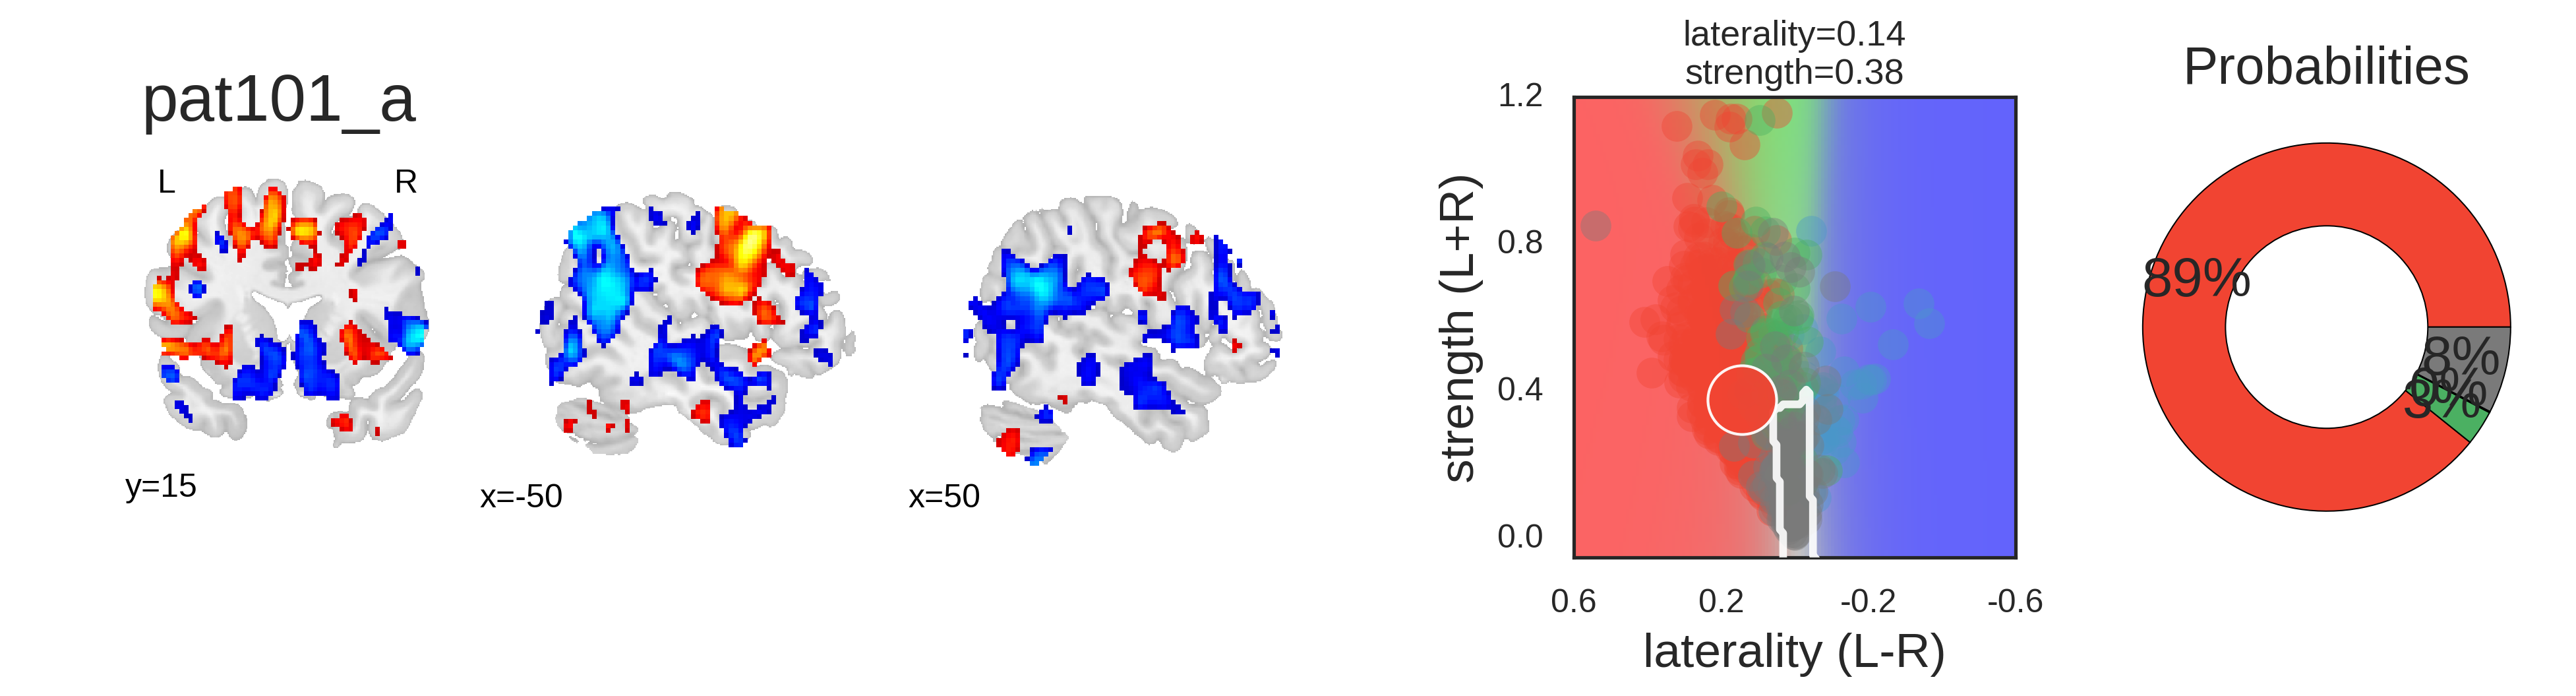

In [159]:
Image.open('../data/interim/tMaps/fig_%s.png'%p_name)

### collect the predicitions from their individual files

In [173]:
big_pred_df = pd.DataFrame()
for p_name in data_df.index:
    try:
        pred_df = pd.read_csv('../data/interim/tMaps/meanTable_%s.csv'%p_name)
        pred_df.index = [p_name]
        big_pred_df = pd.concat([big_pred_df,pred_df])
    except:
        print('did not work for %s!'%p_name)

In [ ]:
big_pred_df.tail()

### get best prediction and add to data_df

In [175]:
# get the most probable class
best_pred_df = pd.DataFrame( big_pred_df[['left','right','bilateral','inconclusive']].idxmax(axis=1) )
best_pred_df.columns = ['pred']
# combine probabilities with decision, drop superfluous columns
big_pred_df = pd.concat([big_pred_df,best_pred_df],axis=1).drop(['Unnamed: 0','Unnamed: 1'],axis=1)
# add predicitons to big table
merge_df = pd.concat([data_df,big_pred_df],axis=1)

In [ ]:
merge_df.tail()

In [191]:
merge_df[merge_df['pred']!='inconclusive'].groupby('code').last().groupby('wada').count().median(axis=1)

wada
bilateral    10.0
left         39.0
right        14.0
dtype: float64

In [193]:
merge_df.shape,merge_df.dropna().shape

((140, 16), (140, 16))

### get one dataset for each patient  

We prioritize conclusive datasets, i.e. if a patient has multiple ones and one of them is inconclusive, we prefer to select the conclusive one. We also prioritize later datasets, i.e. if a patient has multiple conclusive ones, we choose the one done last.

In [194]:
# get last of each prediction type
last_df = merge_df.groupby(['code','pred']).last()
last_df['code'] = last_df.index.get_level_values(0)
last_df['pred'] = last_df.index.get_level_values(1)

# get conc and inconc seperately
conc_df = last_df[last_df['pred']!='inconclusive'].groupby('code').last()
inc_df = last_df[last_df['pred']=='inconclusive'].groupby('code').last()

# drop inconclusive patients from whom we also have conclusive datasets

inc_clean_df = inc_df.drop([x for x in conc_df.index if x in inc_df.index])

In [195]:
conc_df.shape, inc_clean_df.shape

((63, 15), (33, 15))

In [196]:
clean_df = pd.concat([conc_df,inc_clean_df])

In [197]:
clean_df.shape

(96, 15)

### check if ther are only unique patients left

In [198]:
clean_df.index.shape,np.unique(clean_df.index).shape

((96,), (96,))

### store data frame

In [199]:
clean_df.to_csv('../data/interim/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_df.csv')

### summary

We have now a way to weed out inconclusive cases. This will be important later on, when we try to average patients to make prototypical activity maps for each group.


**************

< [Previous](04-mw-make-design-and-summary-maps.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](06-mw-make-group-ims.ipynb)